# Setup

## Imports

In [162]:
from copy import deepcopy
from random import choice
from typing import \
    Callable, \
    List, \
    NewType, \
    Tuple
from matplotlib import pyplot as plt

import numpy as np

### Temporary

In [2]:
from collections import Counter

## Types

In [45]:
Encounter = NewType('Encounter', int)
Position = NewType('Position', Tuple[int, int])
Reward = NewType('Reward', int)

IsGreedy = NewType('IsGreedy', bool)
Move = NewType('Move', Tuple[Position, Encounter, IsGreedy])

## Constants

In [205]:
INIT_POS = Position((0, 0))
NUM_MOVES = 100

# Encounter Types
EMPTY = Encounter(0)
MONSTER = Encounter(1)
TREASURE = Encounter(2)

ENCOUNTER_TO_REWARD = {
    EMPTY: 0,
    MONSTER: -10,
    TREASURE: 10
}

ENCOUNTER_TO_REWARD_ORDERING = [EMPTY, MONSTER, TREASURE]

STARTING_POSITION = Position((0, 0))

VALUE_ITERATION_DISCOUNT = 0.9
VALUE_ITERATION_EPSILON = 1E-1

# Classes

## Cell Class

In [206]:
class Cell:
    def __init__(self, p_empty: float, p_monster: float, p_treasure: float):
        """
        Init with probabilities set
        """
        self._p_empty = p_empty
        self._p_monster = p_monster
        self._p_treasure = p_treasure
        
    @property
    def p_empty(self):
        return self._p_empty
        
    @property
    def p_monster(self):
        return self._p_monster
        
    @property
    def p_treasure(self):
        return self._p_treasure
    
    @property
    def expectation(self):
        ps = self.p_empty, self.p_monster, self.p_treasure
        values = [ENCOUNTER_TO_REWARD[key] for key in ENCOUNTER_TO_REWARD_ORDERING]
        
        return np.sum([p * val for p, val in zip(ps, values)])
    
    def __call__(self) -> Encounter:
        """
        Returns reward
        """
        x = np.random.rand()
        
        if x < self.p_empty:
            return EMPTY
        if x < self.p_monster + self.p_empty:
            return MONSTER
        return TREASURE
    
    def __str__(self) -> str:
        p_empty = self.p_empty
        p_monster = self.p_monster
        p_treasure = self.p_treasure
        
        return f'Probability of Empty: {p_empty:.2f}\nProbability of Monster: {p_monster:.2f}\nProbability of Treasure: {p_treasure:.2f}'

### Testing

In [207]:
cell = Cell(0.2, 0.7, 0.1)
print(cell.expectation)

Counter([cell() for _ in range(100000)])

-6.0


Counter({1: 70031, 0: 20151, 2: 9818})

## Grid Class

In [208]:
class Grid:
    def __init__(self, cells: List[List[Cell]]):
        """
        Init with cells
        """
        
        self.cells = cells
        self.num_rows = len(cells)
        self.num_cols = len(cells[0])
    
    def valid_next_positions(self, position: Position) -> List[Position]:
        """
        Returns list of valid next cells
        """
        
        i, j = position
        
        valid_positions = []
        def add_position(i, j): 
            valid_positions.append(Position((i, j)))
        
        if i > 0:
            add_position(i - 1, j)
        if i < self.num_rows - 1:
            add_position(i + 1, j)
        if j > 0:
            add_position(i, j - 1)
        if j < self.num_cols - 1:
            add_position(i, j + 1)

        return valid_positions
    
    def __iter__(self):
        for i in range(self.num_rows):
            for j in range(self.num_rows):
                pos = Position((i, j))
                yield pos, self[pos]
        
    def __getitem__(self, position: Position):
        i, j = position
        return self.cells[i][j]

### Testing

In [8]:
I, J = 3, 3

cells = []
for _ in range(I):
    row = []
    for _ in range(J):
        x = np.random.rand()
        y = np.random.rand() * (1 - x)
        z = 1 - x - y
        
        probabilities = [x, y, z]
        np.random.shuffle(probabilities)
        
        row.append(Cell(*probabilities))
        
    cells.append(row)

grid = Grid(cells)

print(grid.valid_next_positions((1,1)))
print(grid[1, 1])
print(grid[1, 2] == cells[1][2])

[(0, 1), (2, 1), (1, 0), (1, 2)]
Probability of Empty: 0.45
Probability of Monster: 0.02
Probability of Treasure: 0.53
True


## ModelCell and ModelGrid Classes

In [148]:
class ModelCell(Cell):
    def __init__(self):
        """
        Init, tracking with num encounters etc
        """
        self.value = 0
        self.num_encounters = 0
        self.encounters = {
            EMPTY: 0,
            MONSTER: 0,
            TREASURE: 0
        }
        
        super().__init__(0, 0, 0)
    
    @Cell.p_empty.getter
    def p_empty(self):
        if self.num_encounters == 0:
            return 1/3
        
        return self.encounters[EMPTY] / self.num_encounters

    @Cell.p_monster.getter
    def p_monster(self):
        if self.num_encounters == 0:
            return 1/3
        
        return self.encounters[MONSTER] / self.num_encounters
        
    @Cell.p_treasure.getter
    def p_treasure(self):
        if self.num_encounters == 0:
            return 1/3
        
        return self.encounters[TREASURE] / self.num_encounters
    
    def update(self, encounter: Encounter):
        """
        Update encounters tracking with encounter
        """
        
        self.num_encounters += 1
        self.encounters[encounter] += 1
        
class ModelGrid(Grid):
    def __init__(self, num_rows, num_cols):
        cells = [[ModelCell() for _ in range(num_cols)] for _ in range(num_rows)]
        super().__init__(cells)
    
    def update(self, position: Position, encounter: Encounter):
        """
        Update cell in position with encounter e.g. monster
        """
        
        self[position].update(encounter)
        self.value_iteration()
        
    def value_iteration(self, epsilon=VALUE_ITERATION_EPSILON):
        delta = np.inf
        while delta > epsilon:
            delta = 0
            prev_model_grid = deepcopy(self)

            for pos, cell in prev_model_grid:
                prev_val = cell.value
                valid_positions = self.valid_next_positions(pos)
                additive_value = np.mean([prev_model_grid[pos].value for pos in valid_positions])
                next_val = cell.expectation + VALUE_ITERATION_DISCOUNT * additive_value

                delta = max(delta, abs(next_val - prev_val))
                self[pos].value = next_val

    def print(self, player_pos: Position, use_expectation: bool = True, reveal_all: bool = False) -> str:
        """
        Pretty print board with player's position. Defaults to using cell expectation, else cell value
        """
        strings = []
        cells = self.cells
        
        
        for i in range(self.num_rows):
            for j in range(self.num_cols):
                strings.append('|')
                cell_pos = Position((i, j))
                
                if cell_pos == player_pos:
                    strings.append(' P  | ')
                elif cell_pos in grid.valid_next_positions(player_pos) or reveal_all:
                    cell = self[cell_pos]
                    value = cell.expectation if use_expectation else cell.value
                    strings.append(f'{value:4.1f}| ')
                else:
                    strings.append('   x| ')
            strings.append('\n')
                
        print(''.join(strings))

### Testing

In [149]:
cell = ModelCell()

print(Counter([cell() for _ in range(10000)]))

cell.update(EMPTY)
print(Counter([cell() for _ in range(10000)]))
cell.update(np.random.choice([MONSTER, TREASURE]))
print(Counter([cell() for _ in range(10000)]))

cell.expectation

model_grid = ModelGrid(3, 3)
position = Position((1,1))
model_grid[position] == model_cells[1][1]

print(model_grid[position].expectation == 0)
model_grid.update(position, TREASURE)
print(model_grid[position].expectation == 10)
model_grid.update(Position((1,2)), MONSTER)

player_position = Position((1,0))
model_grid.print(player_position)

Counter({2: 3455, 0: 3320, 1: 3225})
Counter({0: 10000})
Counter({1: 5006, 0: 4994})
True
True
| 0.0| |   x| |   x| 
| P  | |10.0| |   x| 
| 0.0| |   x| |   x| 



## Game Class

In [150]:
class Game:
    def __init__(self, grid: Grid):
        """
        Init with grid
        """
        self.grid = grid
        
    def evaluate(self, pos: Position) -> Encounter:
        return self.grid[pos]()
    
    def print(self, player_pos: Position) -> str:
        """
        Pretty print board with player's position
        """
        strings = []
        grid, cells = self.grid, self.grid.cells
        
        for i in range(grid.num_rows):
            for j in range(grid.num_cols):
                strings.append('|')
                cell_pos = Position((i, j))
                
                if cell_pos == player_pos:
                    strings.append('P| ')
                elif cell_pos in grid.valid_next_positions(player_pos):
                    strings.append(' | ')
                else:
                    strings.append('x| ')
            strings.append('\n')
                
        print(''.join(strings))

### Testing

In [131]:
Game(grid).print(Position((1,2)))

|x| |x| | | 
|x| | | |P| 
|x| |x| | | 



## History Class

In [151]:
class History:
    def __init__(self):
        self.moves: List[Move] = []

    def track(self, move):
        self.moves.append(move)
            
    @property
    def reward(self):
        return Reward(
            np.sum([ENCOUNTER_TO_REWARD[encounter] for _, encounter, _ in self.moves])
        )

## Player Class

In [152]:
StrategyFunction = NewType('StrategyFunction', Callable[[Grid, Position], Cell])

class Player:
    def __init__(self, game: Game, strategy_fn: StrategyFunction, num_moves:int = NUM_MOVES):
        """
        Init with strategy function, model grid, history
        """
        
        self.game = game
        self.strategy_fn = strategy_fn
        self.remaining_moves = num_moves
        self.pos = STARTING_POSITION
        
        self.history = History()
        self.model_grid = ModelGrid(game.grid.num_rows, game.grid.num_cols)
    
    def play_next_move(self, display=False):
        """
        Perform next move according to strategy function
        """
        
        if self.remaining_moves <= 0:
            raise ValueError('Oi! No more moves!')
        
        next_pos, is_greedy = self.strategy_fn(self.model_grid, self.pos)
        encounter = self.game.evaluate(next_pos)
        
        self.model_grid.update(next_pos, encounter)
        
        move = Move((next_pos, encounter, is_greedy))
        self.history.track(move)
        self.pos = next_pos
        self.remaining_moves -= 1
        
        if display:
            print(f'Reward: {self.history.reward}')
            print(f'Move is greedy: {is_greedy}')
            self.model_grid.print(self.pos, reveal_all=True)
        
    
    def play(self, display=False) -> History:
        """
        Play until remaining moves expended, then return History
        """
        while self.remaining_moves:
            self.play_next_move(display)

# Strategy Functions

## $\varepsilon\text{-greedy}$

In [119]:
def epsilon_greedy_maker(epsilon: float) -> StrategyFunction:
    def epsilon_greedy(model_grid: ModelGrid, position: Position) -> Position:
        is_greedy = np.random.rand() > epsilon
        
        valid_positions = model_grid.valid_next_positions(position)
        greedy_position = max(valid_positions, key=lambda p: model_grid[p].value)
        
        if is_greedy:
            return greedy_position, is_greedy
        
        position = greedy_position
        while position == greedy_position:
            position = choice(valid_positions)
            
        return position, is_greedy
    
    return epsilon_greedy

### Testing

In [120]:
greedyhalf = epsilon_greedy_maker(0.5)
player_pos = Position((1,0))
I, J = 3, 3

model_grid = ModelGrid(I, J)
position = Position((1,1))
model_grid.update(position, TREASURE)

model_grid.print(player_pos)

print( greedyhalf(model_grid, player_pos) )

| 0.0| |   x| |   x| 
|   P| |10.0| |   x| 
| 0.0| |   x| |   x| 

((0, 0), False)


## $\alpha\text{-index}$, Maximin, Maximax

In [121]:
def alpha_index_maker(alpha: float) -> StrategyFunction:
    def alpha_index(grid: Grid, position: Position) -> Position:
        def evaluate_position(position: Position) -> float:
            cell = grid[position]
            probabilities = cell.p_empty, cell.p_monster, cell.p_treasure
            
        valid_positions = grid.valid_next_positions(position)
        
    
maximin: StrategyFunction = alpha_index_maker(0)
maximax: StrategyFunction = alpha_index_maker(1)

# Playing

### Setup Random Game

In [185]:
I, J = 3, 3

cells = []
for _ in range(I):
    row = []
    for _ in range(J):
        x = np.random.rand()
        y = np.random.rand() * (1 - x)
        z = 1 - x - y
        
        probabilities = [x, y, z]
        np.random.shuffle(probabilities)
        
        row.append(Cell(*probabilities))
        
    cells.append(row)

grid = Grid(cells)
game_random = Game(grid)

## Setup Actual Game

In [201]:
# [[[empty, monster, treasure]]]
data = [[[0.3878219196112134,0.19759672197559452,0.4145813584131921],[0.37018831461569657,0.02794500443185699,0.6018666809524464],[0.6992744657871455,0.012917539448003224,0.2878079947648513],[0.7551581580257278,0.21883616177828769,0.026005680195984482],[0.02217520649536797,0.8593558949990283,0.11846889850560371]],[[0.6553520279778058,0.2552861011127885,0.08936187090940573],[0.283172417088295,0.17419479253578052,0.5426327903759245],[0.22945274994524922,0.7461638890739508,0.024383360980799962],[0.7609087236740122,0.17005000433317896,0.06904127199280885],[0.034922855165913536,0.49597325775947976,0.4691038870746067]],[[0.16436569193686812,0.7975663084635969,0.038067999599534996],[0.09426376430786765,0.21448465845076425,0.6912515772413681],[0.033037349287953655,0.9059765747471451,0.06098607596490124],[0.7817253912202893,0.11920133225443519,0.09907327652527553],[0.08117608091026218,0.4755560522260003,0.44326786686373754]],[[0.44068247200850585,0.4599243375472921,0.09939319044420203],[0.13747855528933162,0.04062411610008909,0.8218973286105793],[0.08262552114158672,0.5488324749946589,0.36854200386375435],[0.15994884407939858,0.5215699615878777,0.3184811943327237],[0.02503774132988279,0.8599172345994779,0.11504502407063932]],[[0.01982759030885628,0.8376737791237576,0.1424986305673861],[0.6416851854069987,0.28807426567342764,0.07024054891957365],[0.6102308845033342,0.2638689165672785,0.1259001989293873],[0.2510901849738849,0.7414758929487386,0.007433922077376476],[0.2898359244814934,0.12410037921850647,0.5860636963000001]]]

cells = []
for probabilities_row in data:
    row = []
    for probabilities in probabilities_row:
        row.append(Cell(*probabilities))
        
    cells.append(row)
    
grid = Grid(cells)
game = Game(grid)

In [202]:
def run(num_moves=NUM_MOVES, display=False, epsilon_greed=0.2) -> Reward:
    player = Player(
        game,
        epsilon_greedy_maker(epsilon_greed),
        num_moves=num_moves
    )
    
    player.play(display=display)
    return player.history.reward

In [212]:
num_runs = 30
num_moves = 20

runs = []
for i in range(num_runs):
    reward = run(num_moves)
    print(f'Done with run {i+1}, reward: {reward}')
    runs.append(reward)

Done with run 1, reward: 20
Done with run 2, reward: 20
Done with run 3, reward: -90
Done with run 4, reward: 80
Done with run 5, reward: 70
Done with run 6, reward: 50
Done with run 7, reward: 40
Done with run 8, reward: 0
Done with run 9, reward: 100
Done with run 10, reward: 30
Done with run 11, reward: 80
Done with run 12, reward: 60
Done with run 13, reward: 50
Done with run 14, reward: 60
Done with run 15, reward: 90
Done with run 16, reward: -70
Done with run 17, reward: -50
Done with run 18, reward: 40
Done with run 19, reward: 80
Done with run 20, reward: 40
Done with run 21, reward: 50
Done with run 22, reward: -50
Done with run 23, reward: -90
Done with run 24, reward: -40
Done with run 25, reward: 70
Done with run 26, reward: -40
Done with run 27, reward: 50
Done with run 28, reward: 80
Done with run 29, reward: 60
Done with run 30, reward: -70


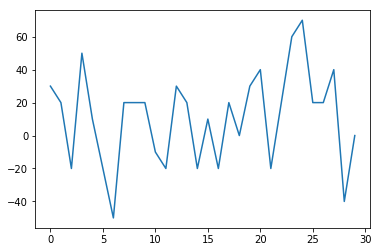

In [211]:
plt.plot(range(len(runs)), runs)

In [168]:
run(num_moves=10, display=True, epsilon_greed=0.3)

Reward: -10
Move is greedy: False
| 0.0| | P  | | 0.0| 
| 0.0| | 0.0| | 0.0| 
| 0.0| | 0.0| | 0.0| 

Reward: -10
Move is greedy: False
| 0.0| |-10.0| | P  | 
| 0.0| | 0.0| | 0.0| 
| 0.0| | 0.0| | 0.0| 

Reward: 0
Move is greedy: True
| 0.0| |-10.0| | 0.0| 
| 0.0| | 0.0| | P  | 
| 0.0| | 0.0| | 0.0| 

Reward: 10
Move is greedy: True
| 0.0| |-10.0| | 0.0| 
| 0.0| | 0.0| |10.0| 
| 0.0| | 0.0| | P  | 

Reward: 10
Move is greedy: True
| 0.0| |-10.0| | 0.0| 
| 0.0| | 0.0| | P  | 
| 0.0| | 0.0| |10.0| 

Reward: 20
Move is greedy: True
| 0.0| |-10.0| | 0.0| 
| 0.0| | 0.0| | 5.0| 
| 0.0| | 0.0| | P  | 

Reward: 30
Move is greedy: True
| 0.0| |-10.0| | 0.0| 
| 0.0| | 0.0| | P  | 
| 0.0| | 0.0| |10.0| 

Reward: 30
Move is greedy: False
| 0.0| |-10.0| | 0.0| 
| 0.0| | P  | | 6.7| 
| 0.0| | 0.0| |10.0| 

Reward: 20
Move is greedy: False
| 0.0| |-10.0| | 0.0| 
| 0.0| | 0.0| | 6.7| 
| 0.0| | P  | |10.0| 

Reward: 20
Move is greedy: False
| 0.0| |-10.0| | 0.0| 
| 0.0| | 0.0| | 6.7| 
| P  | |-10.0| |10

20

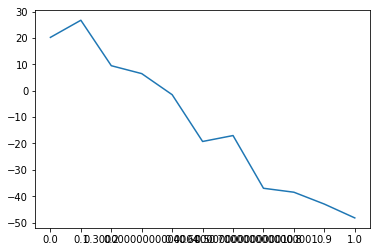

In [184]:
num_moves = 20
num_epochs = 40

eps_rewards = []
for epsilon_greed in np.linspace(0, 1, 11):
    rewards = [run(num_moves=num_moves, display=False, epsilon_greed=epsilon_greed)
               for epoch in range(num_epochs)]
    avg_reward = sum(rewards) / num_epochs
    eps_rewards.append(avg_reward)

plt.xticks(np.arange(11), np.linspace(0, 1, 11))
plt.plot(eps_rewards);